In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv
import numpy as np
import scipy.special as special
from time import time

In [2]:
print(np.pi)

3.141592653589793


6.944288427779873e-23 9450.048718468614
6.944288427779873e-23 9450.048718468614


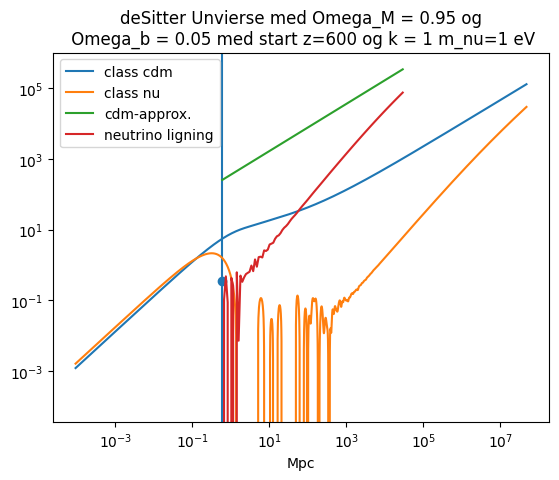

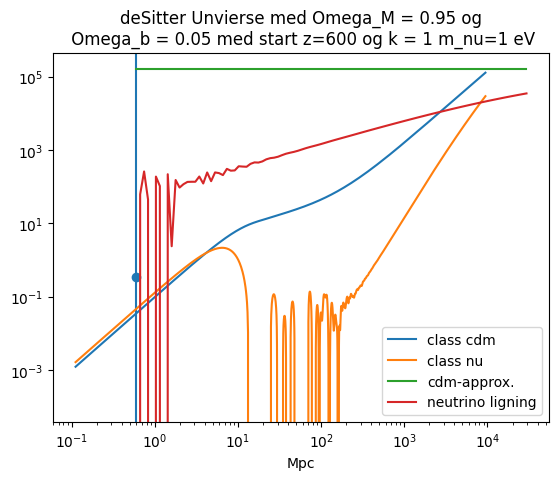

In [3]:
def TEST(kvec=[1],k_ind=0,z=600,mv_test=1 ,   Omega_M = 0.95,Omega_b=0.05,PLOT_FIGUR=True,div_med_a=False):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv


    # henter class data
    #=======================
    delta_class = pts[k_ind]["delta_cdm"]
    #theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    #=======================

    # interpolation af class data
    # ==============================
    tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class)
    delta_init = scipy.interpolate.interp1d(tau_class,delta_class)
    delta_tid = scipy.interpolate.interp1d(tid_class,delta_class)

    neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
    theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
    neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    #a_interp = scipy.interpolate.interp1d(tau_class,a_class)
    #a_interp_tid = scipy.interpolate.interp1d(a_class,tid_class)
    # ===============================

        # valg af z-start værdi
    # ===============================
    a0 = 1/(1+z)
    a_span = [a0,1]
    # ===============================
    # danner start værdier for conformal og fysisk tid og delta_cdm
    # ===============================
    T_ini = float(interp_tau_from_a(a0))
    T_ini_tid = float(interp_tid_from_a(a0))
    T_0 =  float(T_ini_tid)
    delta0 = delta_init(T_ini)
    # ===============================


    # Jeg har skreve cs(a) som c/a i mathmatica så vi definere først c som konstant
    # ===============================
    c = cs(1)
    # ===============================

    # diff ligning i fysisk tid
    # ===============================
    t0 = tid[-1]

    #y0 = np.array([neu_interp(a0),0])
    t = [T_0,tid[-1]]
    a0 = ((T_0)/tid[-1])**(2/3)
    #sol = scipy.integrate.solve_ivp(func,t,y0,args=(a0,))
    # ===============================

    
    t = np.logspace(np.log10(T_0),np.log10(tid[-1]+20000),100)


    def f2(t):
        C1 = np.sqrt(neu_tid(T_0)**2 + (theta_neu_tid(T_0)*a0/ (cs(a0)*k))**2)
        C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
        a = (t/t0)**(2/3)
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        dcdm = delta0/a0 
        D = a*dcdm
        return D + C1*Cos(val) + val**2*a*dcdm*Cos(val)*CosIntegral(val) - C2*Sin(val) + val**2*a*dcdm*Sin(val)*SinIntegral(val) 
    
    #t = np.logspace(np.log10(tid[0],tid[-1]+2000,200)
    b = 1
    if div_med_a ==True:
        b = (t/t0)**(2/3)
        c = a_class
    
    if PLOT_FIGUR==True:
        plt.figure(np.random.randint(1,1000))
        plt.axvline(T_0 )
        plt.loglog(tid_class/c,-delta_class,label="class cdm")
        plt.plot(tid_class/c,-delta_neutrino_class,label="class nu")
        plt.xlabel("Mpc")
        plt.scatter(T_ini_tid,-neu_interp(a0))
        plt.loglog(t,-delta0/a0*Power(t/t0,2/3)/b,label="cdm-approx.")
        plt.loglog(t,-f2(t)/b,label="neutrino ligning")
        plt.legend()
        plt.title("deSitter Unvierse med Omega_M = %s og\n Omega_b = %s med start z=%s og k = %s m_nu=%s eV" %(Omega_M,Omega_b,z,k,mv_test))
    print(tid[0],tid[-1])

t1 = time()

#TEST(    kvec=[1],    k_ind=0,    z=800,    mv_test=1,    Omega_M=0.95,    Omega_b=0.05,    PLOT_FIGUR=True,)
#TEST(    kvec=[1],    k_ind=0,    z=800,    mv_test=1,    Omega_M=0.35,    Omega_b=0.05,    PLOT_FIGUR=True,)
TEST()
TEST(div_med_a=True)

In [ ]:
#TEST(    kvec=[1e-3],    k_ind=0,    z=800,    mv_test=1,    Omega_M=0.95)

In [ ]:
#TEST(    kvec=[1e2],    k_ind=0,    z=800,    mv_test=1,    Omega_M=0.35,    Omega_b=0.05,    PLOT_FIGUR=True,)

In [ ]:
#TEST(kvec=[1],k_ind=0,z=600,mv_test=1,Omega_M = 0.33,Omega_b=0.05)
#plt.title("deSitter Unvierse med Omega_M = %s og Omega_b = %s" %(0.33,0.005))

In [ ]:
#TEST(kvec=[1],k_ind=0,z=600,mv_test=100,Omega_M = 0.95)
#plt.title("neutrino mass = 100 eV")

In [ ]:
#TEST(kvec=[1],k_ind=0,z=600,mv_test=0.1)
#plt.title("neutrino mass = 0.1 eV")

Vi starter i $t_s$ og slutter i $t_0$ (idag)

$\ddot{\delta} +2 H \dot{\delta} + \frac{c_s ^2 k^2}{a^4}\delta = \frac{3}{2} H^2 \delta_{cdm}$

$\delta_{cdm} = \frac{\delta_{cdm,ts}}{a_s} a$

Hvor $a_s =  \left(\frac{t_s}{t_0}\right) ^{2/3}$

$a = \left(\frac{t}{t_0}\right) ^{2/3}$

$ H = \frac{2}{3} \frac{1}{t}$

i Mathmatica:

$ K1 = \delta_{cdm,ts} / a_s$

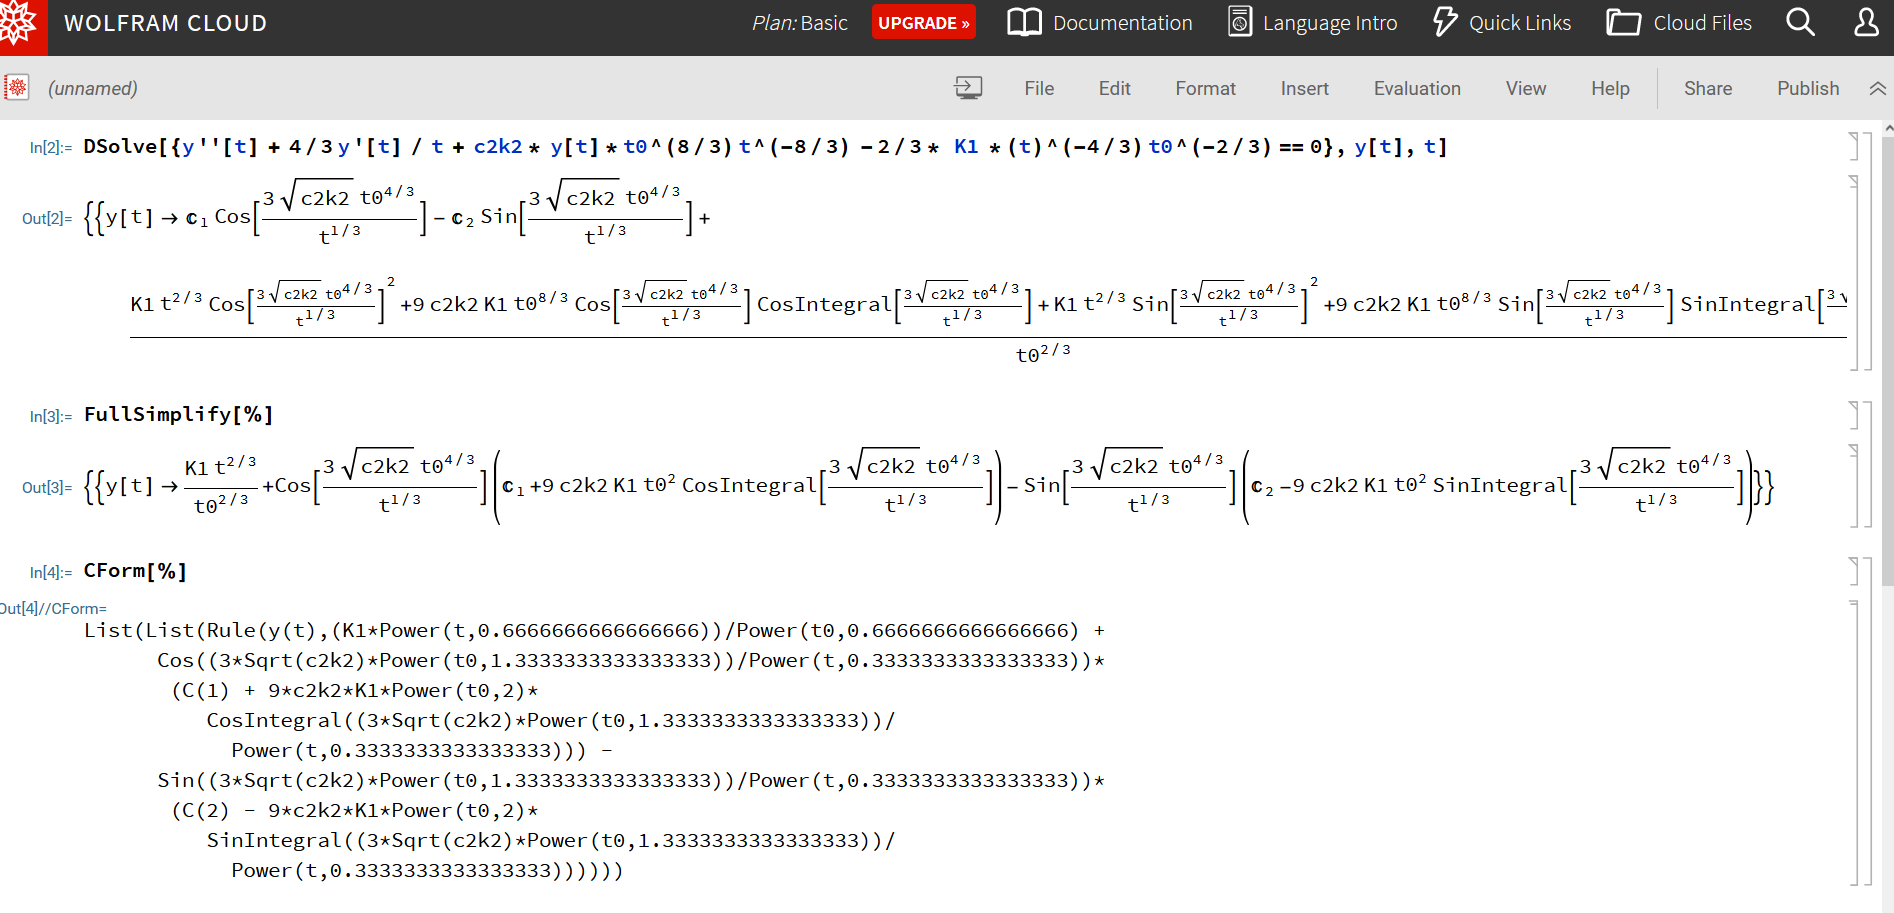

$A = 3 c_s(a=1) k t_0\; B = 3 c_s(a_{ts}) k t_s / a_{ts}$



$S_I A = sinIntegral(A)$

$C_I A = cosIntegral(A)$

$S_I B = sinIntegral(B)$

$C_I B = cosIntegral(B)$

$S_A = sin(A)\; C_A = cos(A) \; S_B = sin(B) \; C_B = cos(B)$

$c_1 = \frac{\delta_{ts}-\delta_{\nu,ts} + \delta(t_s)B^2 C_IB + s_B \delta_{ts} B^2 S_IB - \frac{s_B}{s_A}(\delta(t_0)-\delta_{\nu,t_0} + c_A \delta_{t_0} A^2 C_IA + s_A \delta_{t_0}A^2 S_I A)  }{S_BC_A/S_A - C_B}\;$
$c_2 = \frac{1}{s_A}(\delta_{t_0}-\delta_{\nu,t_0}+c_A \delta_{t_0} A^2 C_IA s_A \delta_{t_0} A^2 S_I A) + \frac{c_A}{s_A}c_1$


$\delta_{\nu} = \delta_{cdm} + \cos(3c_s(a) kt/a) \left(c_1 + \delta_{cdm} (3c_s(a)kt/a)^2cosInt(3c_s(a)kt/a)\right) - \sin(3c_s(a)kt/a)\left(c_2 - \delta_{cdm}(3c_s(a)kt/a)^2SinInt(3c_s(a)kt/a)\right)$


In [ ]:
def sim(kvec=[1],k_ind=0,z=600,mv_test=1 ,   Omega_M = 0.95,conf=True):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,"Omega_b":0.05, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3}

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv


    # henter class data
    #=======================
    klist = np.zeros(len(kvec))
    for k_ind,k in enumerate(kvec):
        delta_class = pts[k_ind]["delta_cdm"]
        #theta_class = pts[k_ind]["theta_cdm"]
        tau_class = pts[k_ind]["tau [Mpc]"]
        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        #=======================

        # interpolation af class data
        # ==============================
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class)
        delta_init = scipy.interpolate.interp1d(tau_class,delta_class)
        delta_tid = scipy.interpolate.interp1d(tid_class,delta_class)

        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
        #a_interp = scipy.interpolate.interp1d(tau_class,a_class)
        #a_interp_tid = scipy.interpolate.interp1d(a_class,tid_class)
        # ===============================

            # valg af z-start værdi
        # ===============================
        a0 = 1/(1+z)
        a_span = [a0,1]
        # ===============================
        # danner start værdier for conformal og fysisk tid og delta_cdm
        # ===============================
        T_ini = float(interp_tau_from_a(a0))
        T_ini_tid = float(interp_tid_from_a(a0))
        T_0 =  float(T_ini_tid)
        delta0 = delta_init(T_ini)
        # ===============================


        # Jeg har skreve cs(a) som c/a i mathmatica så vi definere først c som konstant
        # ===============================
        c = cs(1)
        # ===============================

        # diff ligning i fysisk tid
        # ===============================
        t0 = tid[-1]

        #y0 = np.array([neu_interp(a0),0])
        t = [T_0,tid[-1]]
        a0 = ((T_0)/tid[-1])**(2/3)
        #sol = scipy.integrate.solve_ivp(func,t,y0,args=(a0,))
        # ===============================


        def f2(t):
            C1 = np.sqrt(neu_tid(T_0)**2 + (theta_neu_tid(T_0)*a0/ (cs(a0)*k))**2)
            C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
            dcdm = delta0/a0        
            a = (t/t0)**(2/3)
            val = 3 * cs(a) * k * t0 * np.sqrt(a)        
            return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
        
        H_slut = (2/3) * 1/t0
        a_slut = 1
        bonus = 0
        if conf==True:
            #print(H_slut,theta_neu_tid(t0),1/k**2,H_slut*theta_neu_tid(t0)/k**2)
            bonus = 3 * a_slut * H_slut * theta_neu_tid(t0)/ k**2 
            print(bonus)
        klist[k_ind] = f2(t0) + bonus
    return klist

t1 = time()
s = sim(kvec=list(np.logspace(-4,1,5)))
t2 = time()
print(s)
print(t2-t1)
print("="*20)

t1 = time()
s = sim(kvec=list(np.logspace(-4,1,5)))#,conf=False)
t2 = time()
print(s)
print(t2-t1)


In [ ]:
Omega_M = 0.95
Omega_R = 0
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
H0 = 67 / (3*1e5) # i 1/Mpc
mv_test = 1 # eV
kvec = np.logspace(-3,1,30)
h = 0.6704
cosmo_dict ={'h':h,  'Omega_cdm':Omega_M, "Omega_b":0.05,'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3,
             #'gauge':"newtonian"
            }
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
#print(bg.keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]
mv = mv_test * 1e-6
tranf = cosmo.get_transfer(z=0)
#print(tranf.keys())
prim = cosmo.get_primordial()
#print(prim.keys())

k = tranf['k (h/Mpc)'] * h
#plt.loglog(tranf['k (h/Mpc)'],-tranf["d_ncdm[0]"])

prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")


In [ ]:
test = sim(kvec=list(kvec))


In [ ]:

plt.figure(1)
plt.loglog(k, 2*np.pi**2 * tranf["d_ncdm[0]"]**2* k**(-3) * prim_interp(k) * h**3,label="neutrino")
plt.loglog(kvec, 2*np.pi**2 * test**2 * kvec**(-3) * prim_interp(kvec) * h**3,label="analytic neutrino")
plt.loglog(k, 2*np.pi**2 * tranf["d_cdm"]** 2 *k**(-3) *  prim_interp(k) * h**3,label="matter")
plt.xlim([1e-5,1])
plt.legend()
plt.xlabel("k")
plt.ylabel("P(k)")
plt.title("neutrino power sepctrum for a neutrino of mass %s eV" % mv_test)

In [ ]:
plt.loglog(k,-tranf["d_ncdm[0]"],label="class neutrino")
plt.loglog(kvec, -test,label="neutrino")
a = scipy.interpolate.interp1d(kvec,test)
b = scipy.interpolate.interp1d(k,tranf["d_ncdm[0]"])
klst = np.logspace(-2,0,10)
plt.legend()
#plt.figure(12)
#plt.plot(klst,a(klst)/b(klst))

In [ ]:
def TEST(kvec=[1],k_ind=0,z=600,mv_test=1 ,   Omega_M = 0.95,Omega_b=0.05,PLOT_FIGUR=True):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv


    # henter class data
    #=======================
    delta_class = pts[k_ind]["delta_cdm"]
    theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    #=======================

    # interpolation af class data
    # ==============================
    tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class)
    delta_init = scipy.interpolate.interp1d(tau_class,delta_class)
    delta_tid = scipy.interpolate.interp1d(tid_class,delta_class)
    theta_tid = scipy.interpolate.interp1d(tid_class,theta_class)
    
    neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
    theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
    neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    #a_interp = scipy.interpolate.interp1d(tau_class,a_class)
    #a_interp_tid = scipy.interpolate.interp1d(a_class,tid_class)
    # ===============================

        # valg af z-start værdi
    # ===============================
    a0 = 1/(1+z)
    a_span = [a0,1]
    # ===============================
    # danner start værdier for conformal og fysisk tid og delta_cdm
    # ===============================
    T_ini = float(interp_tau_from_a(a0))
    T_ini_tid = float(interp_tid_from_a(a0))
    T_0 =  float(T_ini_tid)
    delta0 = delta_init(T_ini)
    # ===============================
    # Jeg har skreve cs(a) som c/a i mathmatica så vi definere først c som konstant
    # ===============================
    c = cs(1)
    # ===============================
    # diff ligning i fysisk tid
    # ===============================
    t0 = tid[-1]
    t = [T_0,tid[-1]]
    a0 = ((T_0)/tid[-1])**(2/3)
    # ===============================
    
    t = np.logspace(np.log10(T_0),np.log10(tid[-1]),100)
    delta02 = delta0/(a0)
    def func(a,y):
        delta = y[0]
        delta_dt = y[1]
        delta_dt2 = - 3/2 * delta_dt/ a  - (c*k/H0)**2 * delta / (a**3) + 3/2 * delta02 /a
        return [delta_dt,delta_dt2]
    
    t_span = [T_0,tid[-1]]
    y0 = np.array([neu_tid(T_0),-theta_neu_tid(T_0)])
    sol_tst = scipy.integrate.solve_ivp(func,t_span,y0)
    
    def func(t,y,a0): 
        delta = y[0]
        d_delta = y[1]    
        H = 2/3 * t**(-1)
        a = (t/t0)**(2/3)
        d2_delta = - 2 * H * d_delta - (c*k)**2 * delta/a**4 + 3/2 * (H**2) * delta0 * (a/a0)**2
        d2_delta = -4/3 * d_delta/t - (c*k)**2 /((t/t0)**(8/3)) * delta + 3/2 * (4/9/t**2) * delta0 * ((t/t0)**(2/3)/(a0))**2
        
        return [d_delta,d2_delta]
    
    y0 = np.array([neu_interp(a0),0])
    #y0 = [delta_tid(T_0),0]#-theta_tid(T_0)]
    sol_tst = scipy.integrate.solve_ivp(func,t_span,y0,args=(a0,))
    #plt.plot(sol.t,-sol.y[0],label="sim nu")
    
    def f2(t):
        C1 = np.sqrt(neu_tid(T_0)**2 + (theta_neu_tid(T_0)*a0/ (cs(a0)*k))**2)
        C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
        a = (t/t0)**(2/3)
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        dcdm = delta0/a0 
        D = a*dcdm
        return D + C1*Cos(val) + val**2*a*dcdm*Cos(val)*CosIntegral(val) - C2*Sin(val) + val**2*a*dcdm*Sin(val)*SinIntegral(val) 
    
    def f3(t):
        K = (c**2 * k**2 )/(2/3 * 1/t0)**2
        C1 = np.sqrt(neu_tid(T_0)**2 + (theta_neu_tid(T_0)* a0 ** 1.5 / K**0.5)**2)
        C2 = - 2 * delta0 * K**2 * np.pi / (5 * a0**2)
        #C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
        a = (t/t0)**(2/3)
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        dcdm = delta0/a0 
        D = a*dcdm
        d0 = delta0
        # H0 = 2/3 * 1/ t0
        #return D + C1*Cos(val) + val**2*a*dcdm*Cos(val)*CosIntegral(val) - C2*Sin(val) + val**2*a*dcdm*Sin(val)*SinIntegral(val) 
        return (a*d0*(3*a - 2*K) + 2*Cos(val)*(5*Power(a0,2)*C1 - 4*d0*Power(val,2)*CosIntegral(val))-2*Sin(val)*(5*Power(a0,2)*C2 +  4*d0*Power(K,2)*SinIntegral(val)))/(10.*Power(a0,2)) 
        
    
    
    def f3(t):
        a = (t/t0)**(2/3)
        K = c**2 * k**2 /(H0**2)
        C1 = np.sqrt(neu_tid(T_0) ** 2 + (theta_neu_tid(T_0) * np.sqrt(a**3/K)) ** 2)
        C2 = - 2 * delta0 * K**2 * np.pi / (5 * a0**2)
        d0 = delta0# /2
        return (a*d0*(3*a - 2*K) + 2*Cos((2*Sqrt(K))/Sqrt(a))*(5*Power(a0,2)*C1-4*d0*Power(K,2)*CosIntegral((2*Sqrt(K))/Sqrt(a))) -2*Sin((2*Sqrt(K))/Sqrt(a))*(5*Power(a0,2)*C2 +4*d0*Power(K,2)*SinIntegral((2*Sqrt(K))/Sqrt(a))))/(10.*Power(a0,2)) 
    
    
    
    
    if PLOT_FIGUR==True:
        plt.figure(np.random.randint(1,1000))
        plt.axvline(T_0 )
        plt.loglog(tid_class,-delta_class,label="class cdm")
        plt.plot(tid_class,-delta_neutrino_class,label="class nu")
        plt.xlabel("Mpc")
        plt.scatter(T_ini_tid,-neu_interp(a0))
        plt.loglog(t,-delta0/a0*Power(t/t0,2/3),label="cdm-approx.")
        plt.loglog(t,-delta0/a0**2 *Power(t/t0,4/3),label="cdm $\propto a^2$")
        plt.loglog(t,-f2(t),label="neutrino ligning") 
        plt.loglog(sol_tst.t,-sol_tst.y[0],label="sim nu cdm $\propto a^2$")
        plt.loglog(t,-f3(t),label="neutrino ligning $a^2$")
        plt.legend()
        plt.title("deSitter Unvierse med $\Omega_M =$ %s og\n $\Omega_b =$ %s med start z=%s og k = %s m_nu=%s eV" %(Omega_M,Omega_b,z,k,mv_test))
    return f2(t0)

TEST()

In [ ]:
def TEST(kvec=[1],k_ind=0,z=600,mv_test=1 ,   Omega_M = 0.95,Omega_b=0.05,PLOT_FIGUR=True):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv


    # henter class data
    #=======================
    delta_class = pts[k_ind]["delta_cdm"]
    theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    #=======================

    # interpolation af class data
    # ==============================
    tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class)
    delta_init = scipy.interpolate.interp1d(a_class,delta_class)
    delta_a = scipy.interpolate.interp1d(a_class,delta_class)
    theta_a = scipy.interpolate.interp1d(a_class,theta_class)
    
    neu_a = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    theta_neu_a = scipy.interpolate.interp1d(a_class,theta_neutrino_class)
    neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    #a_interp = scipy.interpolate.interp1d(tau_class,a_class)
    #a_interp_tid = scipy.interpolate.interp1d(a_class,tid_class)
    # ===============================

        # valg af z-start værdi
    # ===============================
    a0 = 1/(1+z)
    a_span = [a0,1]
    # ===============================
    # danner start værdier for conformal og fysisk tid og delta_cdm
    # ===============================
    delta0 = delta_init(a0)
    # ===============================


    # Jeg har skreve cs(a) som c/a i mathmatica så vi definere først c som konstant
    # ===============================
    c = cs(1)
    # ===============================

    # diff ligning i fysisk tid
    # ===============================
    #t0 = tid[-1]

    #y0 = np.array([neu_interp(a0),0])
    #t = [T_0,tid[-1]]
    #a0 = ((T_0)/tid[-1])**(2/3)
    a_span = [a0,1]
    #sol = scipy.integrate.solve_ivp(func,t,y0,args=(a0,))
    # ===============================

    
    #t = np.logspace(np.log10(T_0),np.log10(tid[-1]),100)
    delta02 = delta0/(a0)
    def func(a,y):
        delta = y[0]
        delta_dt = y[1]
        delta_dt2 = - 3/2 * delta_dt/ a  - (c*k/H0)**2 * delta / (a**3) + 3/2 * delta02 /a
        return [delta_dt,delta_dt2]
    
    #t_span = [T_0,tid[-1]]
    y0 = np.array([neu_a(a0),-theta_neu_a(a0)])
    sol_tst = scipy.integrate.solve_ivp(func,a_span,y0)
    
    def func(a,y,a0): 
        delta = y[0]
        d_delta = y[1]    
        d2_delta = -3/2 * d_delta/a - (c*k)**2 / ( a **3 * H0**2 )* delta + 3/2 * delta0/a0 / (a)
        return [d_delta,d2_delta]
    
    y0 = np.array([neu_interp(a0),0])
    #y0 = [delta_tid(T_0),0]#-theta_tid(T_0)]
    sol_tst = scipy.integrate.solve_ivp(func,a_span,y0,args=(a0,))
    #plt.plot(sol.t,-sol.y[0],label="sim nu")  
    def func2(a,y,a0): 
        delta = y[0]
        d_delta = y[1]    
        d2_delta = -3/2 * d_delta/a - (c*k)**2 / ( a **3 * H0**2 )* delta + 3/2 * delta0/a0**2 
        return [d_delta,d2_delta]
    
    y0 = np.array([neu_interp(a0),0])
    #y0 = [delta_tid(T_0),0]#-theta_tid(T_0)]
    sol_tst_2 = scipy.integrate.solve_ivp(func2,a_span,y0,args=(a0,))
    #plt.plot(sol.t,-sol.y[0],label="sim nu")
    
    def f2(a):
        K = c**2 * k**2 /(H0**2)
        C1 = np.sqrt(neu_a(a0)**2 + (theta_neu_a(a0)*np.sqrt(a**3 / K))**2)
        C2 = 2 * np.pi * K * delta0/a0
        d0 = delta0
        return (a*d0 + a0*C1*Cos((2*Sqrt(K))/Sqrt(a)) +4*d0*K*Cos((2*Sqrt(K))/Sqrt(a))*CosIntegral((2*Sqrt(K))/Sqrt(a)) -a0*C2*Sin((2*Sqrt(K))/Sqrt(a)) +         4*d0*K*Sin((2*Sqrt(K))/Sqrt(a))*SinIntegral((2*Sqrt(K))/Sqrt(a)))/a0

    
    def f3(a):
        K = c**2 * k**2 /(H0**2)
        C1 = np.sqrt(neu_a(a0) ** 2 + (theta_neu_a(a0) * np.sqrt(a**3/K)) ** 2)
        C2 = - 2 * delta0 * K**2 * np.pi / (5 * a0**2)
        d0 = delta0# /2
        return (a*d0*(3*a - 2*K) + 2*Cos((2*Sqrt(K))/Sqrt(a))*(5*Power(a0,2)*C1-4*d0*Power(K,2)*CosIntegral((2*Sqrt(K))/Sqrt(a))) -2*Sin((2*Sqrt(K))/Sqrt(a))*(5*Power(a0,2)*C2 +4*d0*Power(K,2)*SinIntegral((2*Sqrt(K))/Sqrt(a))))/(10.*Power(a0,2)) 
    
    a = np.logspace(np.log10(a0),0,100)
    if PLOT_FIGUR==True:
        plt.figure(np.random.randint(1,1000))
        plt.axvline(a0 )
        plt.loglog(a_class,-delta_class,label="class cdm")
        plt.plot(a_class,-delta_neutrino_class,label="class nu")
        plt.xlabel("a")
        #plt.scatter(T_ini_tid,-neu_interp(a0))
        plt.loglog(a,-delta0/a0*a,label="cdm-approx.")
        plt.loglog(a,-delta0/a0**2 *a**2,label="cdm $\propto a^2$")
        #plt.loglog(a,f2(a),label="neutrino ligning") 
        
        #plt.loglog(sol_tst.t,-sol_tst.y[0],label="sim nu cdm $\propto a^2$")
        plt.loglog(sol_tst.t,-sol_tst.y[0],label="sim nu cdm $\propto a$")
        plt.loglog(a,-f2(a),"-.",label="neutrino ligning") 
        plt.loglog(sol_tst_2.t,-sol_tst_2.y[0],label="sim nu cdm $\propto a^2$")
        plt.loglog(a,-f3(a),"-.",label="neutrino ligning $a^2$")
        plt.legend()
        plt.title("deSitter Unvierse med $\Omega_M =$ %s og\n $\Omega_b =$ %s med start z=%s og k = %s m_nu=%s eV" %(Omega_M,Omega_b,z,k,mv_test))
        
    return f2(a0)

TEST()


In [ ]:
TEST()
plt.xlim([1e-3,1])

In [ ]:
TEST(kvec=[0.01])


In [ ]:
TEST(kvec=[10])

In [ ]:
#Her har jeg lige testet om tingene virker i conformal time og det gør det umildbart.

def TEST_tau(kvec=[1],k_ind=0,z=600,mv_test=1 ,   Omega_M = 0.95,Omega_b=0.05,PLOT_FIGUR=True):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
        #return np.cos(x)**2 / x**2 + np.sin(x)/x
        #return np.cos(x)**2 * (6/x**2 - 1/x**2) + np.sin(x) * (1/x-2/x**3)
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv


    # henter class data
    #=======================
    delta_class = pts[k_ind]["delta_cdm"]
    theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    #=======================

    # interpolation af class data
    # ==============================
    tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class)
    delta_init = scipy.interpolate.interp1d(a_class,delta_class)
    delta_a = scipy.interpolate.interp1d(a_class,delta_class)
    theta_a = scipy.interpolate.interp1d(a_class,theta_class)
    
    neu_a = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    theta_neu_a = scipy.interpolate.interp1d(a_class,theta_neutrino_class)
    neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    #a_interp = scipy.interpolate.interp1d(tau_class,a_class)
    #a_interp_tid = scipy.interpolate.interp1d(a_class,tid_class)
    # ===============================

        # valg af z-start værdi
    # ===============================
    a0 = 1/(1+z)
    a_span = [a0,1]
    tau0 = interp_tau_from_a(a0)
    # ===============================
    # danner start værdier for conformal og fysisk tid og delta_cdm
    # ===============================
    delta0 = delta_init(a0)
    # ===============================

    tau = np.logspace(np.log10(tau0),np.log10(tau_class[-1]),100)
    #print(tau)
    a = np.logspace(np.log10(a0),1,100)
    # Jeg har skreve cs(a) som c/a i mathmatica så vi definere først c som konstant
    # ===============================
    c = cs(1)
    delta02 = delta0/(a0)
    def f2(tau):
        a = 1/4 * H0**2 * tau**2
        K = c**2 * k**2 /(H0**2)
        C1 = np.sqrt(neu_a(a0)**2 + (theta_neu_a(a0)*np.sqrt(a**3 / K))**2)
        C1 = np.sqrt(neu_a(a0)**2 + (theta_neu_a(a0)/(k*cs(a0)))**2)
        C2 = 2 * np.pi * K * delta0/a0
        d0 = delta0
        return (a*d0 + a0*C1*Cos((2*Sqrt(K))/Sqrt(a)) +4*d0*K*Cos((2*Sqrt(K))/Sqrt(a))*CosIntegral((2*Sqrt(K))/Sqrt(a)) -a0*C2*Sin((2*Sqrt(K))/Sqrt(a)) +         4*d0*K*Sin((2*Sqrt(K))/Sqrt(a))*SinIntegral((2*Sqrt(K))/Sqrt(a)))/a0
    plt.loglog(tau,-f2(tau))
    plt.figure(121341)
    plt.loglog(a_class,1/4 * H0**2 * tau_class**2)
    plt.loglog(a_class,a_class)
    plt.loglog(a_class,-delta_neutrino_class)
    #plt.loglog(a_class,-f2(1/4 * H0**2 * tau_class**2))
    plt.loglog(a,-f2(tau))
    plt.title("Tau")
    return 2*cs(a)*np.sqrt(a) /H0

TEST_tau()
    

In [ ]:
f = lambda x: np.cos(x)**2 / x**2 + np.sin(x)/x

g = lambda x: special.sici(x)[1]
x = np.linspace(0.5,42,100)
plt.plot(x,f(x),x,g(x))

In [ ]:
# conformal time

def func(tau,y):
    delta = y[0]
    d_delta = y[1]
    
    d2_delta = - 2/tau * d_delta + 6/tau**2 * delta_M
    return [d_delta,d2_delta]

    


# i wolfrma cloud 
 løsning:  $$\delta_{\nu} ^{(2)} = \frac{c_1}{\tau} + c_2 + 6 \delta_M^{(2)} \log{\tau}$$